In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd 

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
import torchvision as tv

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


In [2]:
flickr_dir = '/datasets/ee285f-public/flickr_landscape/'
wikiar_dir = '/datasets/ee285f-public/wikiart/Genre'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [3]:
my_dir = os.getcwd()
print(my_dir)
wikiar_my_dir = os.path.join(my_dir, 'wikiart')


/datasets/home/home-02/58/258/jil046/ECE 285/Cycle-GAN


In [ ]:
images_dir = wikiar_dir
images_dir = os.path.join(images_dir, 'wikiart.zip')
import zipfile
zip_ref = zipfile.ZipFile(images_dir, 'r')
zip_ref.extractall(my_dir)
zip_ref.close()

In [4]:

class FlickrDataset(td.Dataset):
    def __init__(self, root_dir, image_size=(190, 190)): 
        super(FlickrDataset, self).__init__() 
        
        self.image_size = image_size 
        self.images_dir = root_dir
        files = os.listdir(self.images_dir)
        self.img_path = []
        for i in range(8):
            files_images_dir = os.path.join(self.images_dir, files[i])
            files_files = os.listdir(files_images_dir)
            length = len(files_files)
            for idx in range(length):
                self.img_path.append(os.path.join(files_images_dir, files_files[idx]))
        
    def __len__(self): 
        return len(self.img_path)
    def __repr__(self):

        return "NeuralTransferDataset(image_size={})". \
            format(self.image_size)
    def __getitem__(self, idx): 
        img = Image.open(self.img_path[idx])#.convert('RGB')

        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
#             tv.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        '''transform the image into desired output'''
        x = transform(img) 
        '''define t and assign it as the image's class'''
        return x

class WikiartDataset(td.Dataset):
    def __init__(self, root_dir, image_size=(256, 256)): 
        super(WikiartDataset, self).__init__() 
        
        self.image_size = image_size 
        
        file_list = ["Abstract_Expressionism", "High_Renaissance", "Impressionism"]
        self.img_idx = []
        for item in file_list:
            images_dir = os.path.join(root_dir, item)
            files = os.listdir(images_dir)
            length = len(files)
            for i in range(length):
                self.img_idx.append(os.path.join(images_dir, files[i]))
        
    def __len__(self): 
        return len(self.img_idx)
    def __repr__(self):

        return "NeuralTransferDataset(image_size={})". \
            format(self.image_size)
    def __getitem__(self, idx): 
        img = Image.open(self.img_idx[idx])#.convert('RGB')

        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
#             tv.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        '''transform the image into desired output'''
        x = transform(img) 
        '''define t and assign it as the image's class'''
        return x



In [5]:
flickr_set = FlickrDataset(flickr_dir)
wikiar_set = WikiartDataset(wikiar_my_dir)


In [24]:
print(len(flickr_set))
print(len(wikiar_set))


3788
4176


In [6]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    

In [7]:
loader = transforms.Compose([
    transforms.Resize((256, 256)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

torch.Size([1, 3, 256, 256])


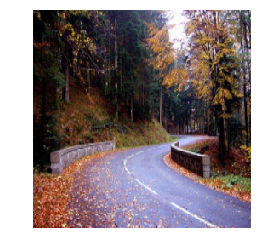

In [8]:
# for i in range(10):
content_img = image_loader(flickr_set.img_path[2000+8]) #2008

print(content_img.size())

plt.figure()
imshow(content_img)

torch.Size([1, 3, 256, 256])


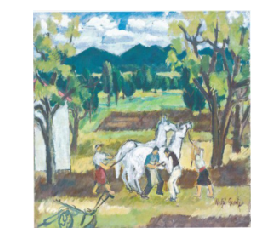

In [10]:
style_img = image_loader(wikiar_set.img_idx[-7]) # -7

print(style_img.size())

plt.figure()
imshow(style_img)


In [13]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input



In [14]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()


In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


In [16]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses



In [17]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


In [18]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=None, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img


In [19]:
# plt.figure()
# imshow(input_img, title='Input Image')
style_weight_list = [1e6, 1e5, 1e4, 1e3]
output = []
# for i in range(len(style_weight_list)):
input_img = content_img.clone()
output.append(run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=style_weight_list[1]))



Building the style transfer model..
Optimizing..


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 13.076138 Content Loss: 10.309984

run [100]:
Style Loss : 6.108957 Content Loss: 8.568979

run [150]:
Style Loss : 3.337816 Content Loss: 7.751865

run [200]:
Style Loss : 2.059295 Content Loss: 7.048165

run [250]:
Style Loss : 1.483405 Content Loss: 6.517152

run [300]:
Style Loss : 1.207178 Content Loss: 6.227281



In [20]:
# plt.figure()
# imshow(output)

# # sphinx_gallery_thumbnail_number = 4
# # plt.axis('off')
# plt.ioff()
# plt.show()

# fig, axes = plt.subplots(ncols=4, figsize=(12, 12))
# # fig.suptitle('images for alpha/beta={} and l={}'.format(1e-5, 4),fontsize=16 )

# plot_all(output, fig, axes)




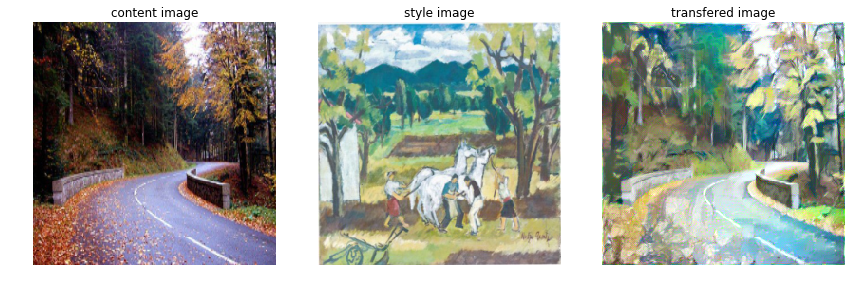

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 12))
# fig.suptitle('images for alpha/beta={} and l={}'.format(1e-5, 4),fontsize=16 )

plot_all([content_img.clone(), style_img.clone(), output[0]], fig, axes)


In [22]:

def clip(img0):
    img = img0[0].cpu().detach().numpy()
    img = np.moveaxis(img, [0, 1, 2], [2, 0, 1]) 
#     img = (img+1)/2
#     img[img<0] = 0
#     img[img>1] = 1
    return img

def plot_all(img0, fig, axes):
    img = []
    for i in range(len(img0)):
#         img.append([])
        img.append(clip(img0[i]))
#     for i in range(len(axes)):
#         axes[i].clear()
    for i in range(len(axes)):
        axes[i].imshow(img[i], )
        
        axes[i].axis('off')
    axes[0].set_title('content image')
    axes[1].set_title('style image')
    axes[2].set_title('transfered image')
    plt.tight_layout() 
    fig.canvas.draw()  
    plt.show()

In [ ]:
import numpy as np
b = np.array([2, 2, 5])
c = np.array([1, 4, 6])

a = np.zeros((b.shape))

# a[b-c<0] = 0
a[b-c>=0] = 1

# a = np.array(np.where(b>c))

print(a)
